In [17]:
#pip install google-cloud-storage
#pip install python-dotenv

In [18]:
#インポート文
import tweepy
import pandas as pd

import nlplot
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
from plotly.offline import iplot

from datetime import datetime,timezone
import pytz
import datetime

import os
from google.cloud import storage
from dotenv import load_dotenv

In [19]:
#Google Cloudの設定
key_name ="./key/storage-nobu.json"
bucket_name = "tweet_csv_upload_bucket"
file_upload = 'tweet.csv'
file_name = './data/tweet.csv'

In [20]:
load_dotenv('.env') 
consumer_key = os.environ.get("consumer_key")
consumer_secret = os.environ.get("consumer_secret")
access_token = os.environ.get("access_token")
access_token_secret = os.environ.get("access_token_secret")
bearer_token = os.environ.get("bearer_token")

In [21]:
#認証
client=tweepy.Client(
     consumer_key=consumer_key,
     consumer_secret=consumer_secret,
     access_token=access_token,
     access_token_secret=access_token_secret,
     bearer_token=bearer_token,
 )

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [22]:
#tweets = tweepy.Cursor(api.search_tweets,q=word,lang='ja',since_id=before,until=now).items(1000) #指定文字検索
tweets = tweepy.Cursor(api.user_timeline,screen_name="ijuin_sugaku").items(300) #タイムライン検索

def change_time_JST(time):
    utc = datetime.datetime(time.year, time.month,time.day, \
    time.hour,time.minute,time.second, tzinfo=timezone.utc)
    jst = utc.astimezone(pytz.timezone("Asia/Tokyo"))
    str_time = jst.strftime("%Y-%m-%d_%H:%M:%S")
    return str_time

tweet_data = []
for tweet in tweets:
    
    tweet_time = change_time_JST(tweet.created_at) #ツイート時刻とユーザのアカウント作成時刻を日本時刻にする
    create_account_time = change_time_JST(tweet.user.created_at)
    
    tweet_data.append([ #tweet_dataの配列に取得したい情報を入れていく
        tweet.id,
        tweet_time,
        tweet.text,
        tweet.favorite_count, 
        tweet.retweet_count, 
        tweet.user.screen_name,
        tweet.user.name,
        tweet.user.description,
        tweet.user.friends_count,
        tweet.user.followers_count,
        create_account_time,
        tweet.in_reply_to_status_id_str,
        tweet.in_reply_to_user_id_str,
        tweet.coordinates,
        tweet.user.verified
                       ])

columns=[
    'Tweet_ID',
    'Tweet_TimeDate(JST)',
    'Tweet_Text',
    'Like',
    'Num_of_Retweets',
    'Account_ID',
    'Account_Name',
    'Description',
    'Num_of_Follow',
    'Num_of_Follower',
    'Account_Create_Date',
    'Retweet_Tweet_ID',
    'Retweet_Account_ID',
    'Place',
    'Is_Badge'
    ]

df = pd.DataFrame(tweet_data,columns=columns)

file_name='./data/tweet.csv'

df.to_csv(file_name,encoding='utf-8-sig',index=False)

In [23]:
#文字をきれいにする

import re
import neologdn

def cleaning_text(text):
    #全角・半角の統一と重ね表現の除去
    normalized_text = neologdn.normalize(text)
    
    #\nの削除
    text_without_n = re.sub(r'\n', '', normalized_text)
    
    #URLの削除
    text_without_url = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text_without_n)
    
    #桁区切りの数字を除去
    tmp = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text_without_url)
    
    #数字も全て0に置き換え
    text_replaced_number = re.sub(r'\d+', '0', tmp)
   
    #RTを削除
    text_replaced_re = re.sub(r'^RT.*\n?', '', text_replaced_number)
    
    #RTを置き換え(上で削除することにした)
    #text_replaced_re = re.sub(r'RT @\w+\s?:', 'RT', text_replaced_number)
    
    #メンションを削除
    text_replaced_mention = re.sub(r'.*@.*\n?', '', text_replaced_re) 
    
    #メンションを置き換え(上で削除することにした)
    #text_replaced_mention = re.sub(r'@\w+\s?', '@', text_replaced_re)
    
    #\の削除
    text_replaced_en = re.sub(r'\\', ' ', text_replaced_mention)
    return text_replaced_en

In [24]:
df['Tweet_Text'] = df['Tweet_Text'].apply(cleaning_text)

In [25]:
#文字が入っていない行を削除
df = df[df['Tweet_Text'].str.strip().astype(bool)]

In [26]:
df.to_csv(file_name,encoding='utf-8-sig',index=False)

In [27]:
client = storage.Client.from_service_account_json(key_name)

In [13]:
client = storage.Client.from_service_account_json(key_name)
bucket = client.get_bucket(bucket_name)
blob = bucket.blob(file_upload)
blob.upload_from_filename(file_name)

可視化

In [28]:
#形態素解析
import MeCab

def sep_by_mecab(text):
    m = MeCab.Tagger(r'-d "C:\\app\\MeCab\\dic\\ipadic" -u "C:\\app\\MeCab\\dic\\NEologd\\NEologd.20200910-u.dic"') 
    node = m.parseToNode(text)

    word_list=[]    
    while node:
        hinshi = node.feature.split(",")[0]
        #名詞、動詞、形容詞のみを抽出する
        if hinshi in ["名詞","動詞","形容詞"]:
            origin = node.feature.split(",")[6]
            #抽出したくない単語を、stopwprdとして設定する
            if origin not in ["*","する","いる","なる","てる","れる","ある","こと","もの"] :
                word_list.append(origin)
        node = node.next

    return word_list

In [29]:
df['Tweet_Text'] = df['Tweet_Text'].apply(sep_by_mecab)
print(df['Tweet_Text'])

0             [内容, 確認, これ, パ, 出す, くれる, TEX, コマンド, の, 良い]
1            [GPT, ちゃん, 演習問題, ちょうだい, いう, 出題, くれる, の, 勉強]
2          [つよい, バルサミコ酢, つよい, きんつば, 貰う, 緩募, バルサミコ酢, レシピ]
3      [やる, 楽しい, 笑顔, アーカイブ, 動画, 視聴, 無料, できる, データ分析, 気...
4                               [明日, やる, 無料, すう, がく, ぶん]
                             ...                        
294            [裏, 弊社, 社長, 耐久, 企画, 考える, 成果, 出す, 発表, ほしい]
295    [現場, 聴ける, 役得, すぎる, 熱量, みんな, 体感, 欲しい, いつか, 対面, ...
296                          [トップバッター, めちゃくちゃ, 楽しい, 楽しい]
297                                 [オープニング, はじまる, Vサイン]
298          [あと, 0分, はじまる, 明日, 夜, やる, 是非, 覗く, みる, くださる]
Name: Tweet_Text, Length: 225, dtype: object


In [30]:
npt = nlplot.NLPlot(df, target_col='Tweet_Text')

In [31]:
npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
)

100%|██████████| 225/225 [00:00<00:00, 48385.89it/s]


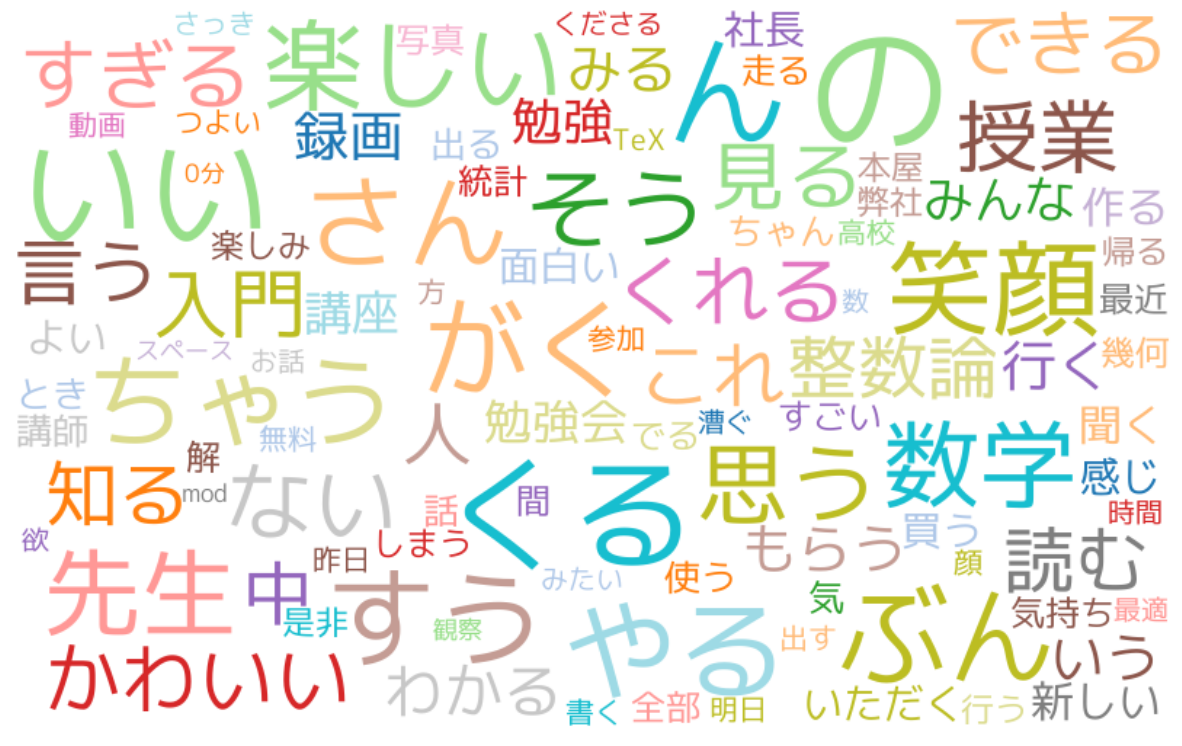

In [32]:
#wordcloudの作成
fig_wc = npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
)
plt.figure(figsize=(15, 25))
plt.imshow(fig_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
npt.build_graph(min_edge_frequency=3)

fig_co_network = npt.co_network(
    title='Co-occurrence network',
    save=True
)
iplot(fig_co_network)

node_size:15, edge_size:22
